# Creating synthetic data: 
## An actual image, advected (warped, pixels remapped)

First just test warping and brightness modulation. Then below, use an actual candidate wave with properties from the literature. 

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
#from openpiv import tools, pyprocess, validation, filters, scaling 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

from scipy import ndimage

In [32]:
!ls -1 DATA/*9_06_16*png

DATA/image_2_2022_09_06_16_15_00Z.png
DATA/image_3_2022_09_06_16_45_00Z.png


In [33]:
img = imageio.v2.imread('DATA/image_2_2022_09_06_16_15_00Z.png')

In [34]:
red = img[:,:,0] # just the red channel 

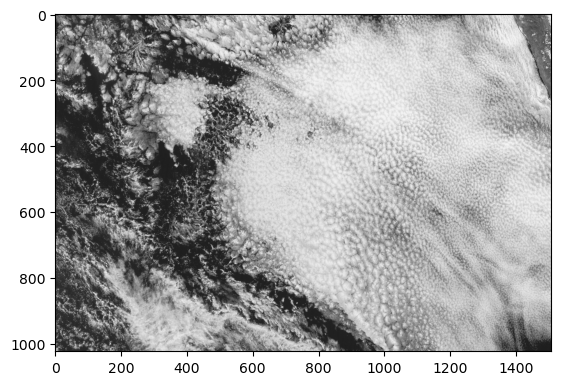

In [35]:
plt.imshow(-red, cmap='Greys') #imshow flips y axis rel. to pcolormesh

In [36]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)

# Create a velocity (a displacement: units pixels) 30, big warp 
xmotion = 30*np.sin(2 * np.pi * X / 300)
ymotion = 30*np.sin(2 * np.pi * Y / 500)

# vertical displacement for albedo modulation. For a wave, Z and divergent wind are in phase, right? 
# MAKE REAL WAVE PHYSICS HERE

zdisplacement = xmotion/30 + ymotion/30

In [37]:
warped = ndimage.map_coordinates(-red,[Y+ymotion, X+xmotion])

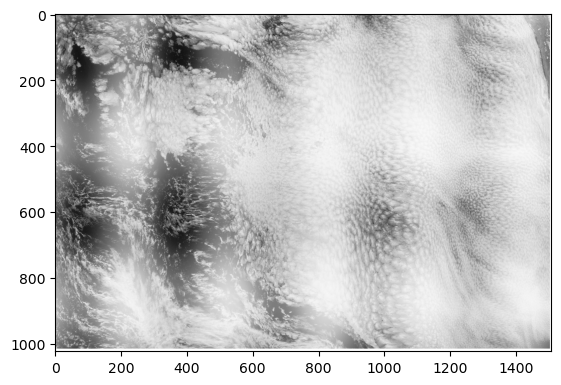

In [38]:
# modulate brightness with zdisplacement
modulated = warped *(1 + 0.3*zdisplacement)
plt.imshow(modulated, cmap='Greys')

# Actual wave paremeters, warping and modulating 

"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

In [39]:
# Pixel size: nominal 
DX = 2000             # m, pixel size (nominal, this is just an image)

# Mean wind: SE-NW and with divergence 
U = -5                # m/s
dUdx = 1e-5           # /s, 1e-5 is 1 m/s per 100km 
V = 5                 # m/s
dVdy = 1e-5           # /s, 1e-5 is 1 m/s per 100km 

# Wave 
cphase = 15           # m/s
period = 3600         # s
wavelength = 55*1000. # meters
direction = 45        # navigation angle or propagation direction in degrees (45 = NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  


# Coordinates in meters 
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

In [40]:
# Winds are derived from the above 

In [42]:
u = U + dUdx*Xm 
v = V + dVdy*Ym

In [21]:
(X-X.mean())*DX

array([[-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.],
       [-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.],
       [-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.],
       ...,
       [-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.],
       [-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.],
       [-1507000., -1505000., -1503000., ...,  1503000.,  1505000.,
         1507000.]])

## Animation displays for time-dependent xmotion,ymotion

NOTHING WORKS HERE YET, JUST HACKING AROUND, SEE OTHER SYNTHETIC NOTEBOOK FOR EXAMPLE OF ANIMATION

In [43]:
# Constants for this animation 
time_steps = 10             # Number of time steps 
time_resolution = 2.4*3600  # seconds

# Create a grid to contain the results (an array at each time)
NX = red.shape[1]
NY = red.shape[0]
grid = np.zeros((NY, NX, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for t in range(time_steps):
    
    wave_modulation = np.sin(X*DX * (2 *np.pi / wavelength) +\
                             Y*DX * (2 *np.pi / wavelength) -\
                             t*time_resolution *cphase/wavelength * (2 *np.pi) )
                      #np.sin(t * (2 * np.pi) * wave_speed) 
        
# Create image by advecting original red image, wave xmotion plus mean wind
    grid[:,:,t] = ndimage.map_coordinates(-red,[Y+(ymotion+20)*t/5., X+(xmotion+20)*t/5.] )

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    #grid[:, :, t] *= (1 + 0.3*wave_modulation)

In [44]:
grid.shape

(1024, 1508, 10)

NameError: name 'cloud_growth_time' is not defined

Error in callback <function _draw_all_if_interactive at 0x7fcd71f0c3a0> (for post_execute):


NameError: name 'cloud_growth_time' is not defined

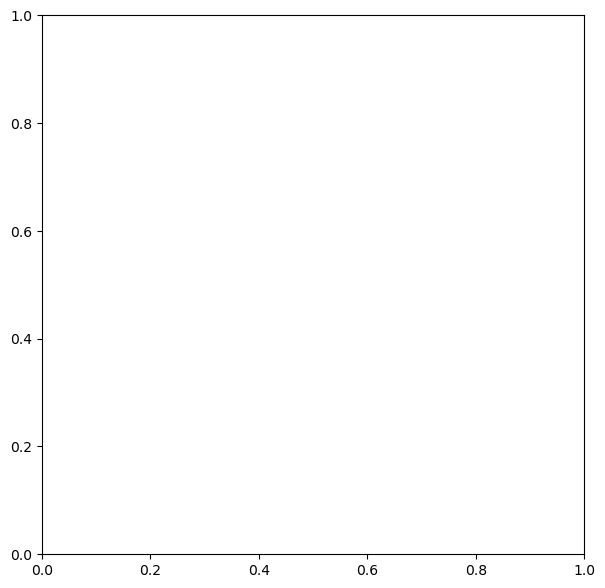

In [30]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))  

# Function to initialize the animation at frame 10 
def init():
    im = ax.pcolormesh(grid[:, :, 0],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step 0')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    return [im]

# Function to animate the frames
def animate(t):
    im = ax.pcolormesh(grid[:, :, t],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step {t}')
    return [im]

# Create an animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=22, repeat=True)

# Display the animation in the Jupyter Notebook
HTML(ani.to_jshtml())


In [ ]:
ani.save('stratocu_waves/DATA/synthetic_scwaves2.mp4',writer='ffmpeg', fps=5)